# C-score Analysis Showcase

This notebook demonstrates how to use C-scores to analyze the commonness and divergence of gene expression responses across different comparisons.

## What are C-scores?

C-scores quantify whether genes show **common** or **divergent** responses across two different comparisons:

- **Positive C-scores**: Genes respond in the same direction (both up or both down)
- **Negative C-scores**: Genes respond in opposite directions (up in one, down in another)
- **Zero/near-zero C-scores**: No relationship or independent responses
- **Magnitude**: Larger absolute values indicate stronger commonness/divergence

We'll explore three key scenarios: **Independent**, **Common**, and **Divergent** responses.


## Setup

First, let's import the necessary libraries and C-score functions:


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Import C-score functionality
try:
    from cscore.core import compute_score
    print("C-score module loaded successfully")
except ImportError:
    print("please install cscore: pip install -e .")
    print("   or run this notebook from the cscore repository root")


## Data Generation Functions

Let's create functions to simulate different biological scenarios:


In [5]:
def generate_gene_data(n_genes=1000, scenario="common", seed=42, noise_level=0.3):
    """
    Generate simulated differential expression data for two comparisons.
    
    Parameters:
    -----------
    n_genes : int
        Number of genes to simulate
    scenario : str
        Type of relationship ("common", "divergent", "mixed", "independent")
    seed : int
        Random seed for reproducibility
    noise_level : float
        Amount of noise to add (0 = perfect correlation, 1 = high noise)
    
    Returns:
    --------
    tuple: (comparison1_data, comparison2_data) as numpy arrays
           Each array has shape (n_genes, 2) with columns [fold_change, fdr]
    """
    rng = np.random.default_rng(seed)
    
    # Generate base fold changes
    fc1 = rng.normal(0, 1.0, n_genes)
    
    if scenario == "common":
        # Genes with similar responses in both comparisons
        fc2 = fc1 + rng.normal(0, noise_level, n_genes)
        description = "Genes respond similarly in both comparisons"
        
    elif scenario == "divergent":
        # Genes with opposite responses
        fc2 = -fc1 + rng.normal(0, noise_level, n_genes)
        description = "Genes respond oppositely in the two comparisons"
        
    elif scenario == "mixed":
        # Mix of common and divergent responses
        mask = rng.random(n_genes) < 0.5
        fc2 = np.where(mask, 
                      fc1 + rng.normal(0, noise_level, n_genes),  # Common
                      -fc1 + rng.normal(0, noise_level, n_genes))  # Divergent
        description = "Mix of common and divergent responses"
        
    elif scenario == "independent":
        # Independent responses (no relationship)
        fc2 = rng.normal(0, 1.0, n_genes)
        description = "Independent responses (no relationship)"
        
    else:
        raise ValueError(f"Unknown scenario: {scenario}")
    
    # Generate FDR values (20% significant genes, 80% non-significant)
    sig_fraction = 0.2
    sig_mask = rng.random(n_genes) < sig_fraction
    
    fdr1 = np.where(sig_mask, 
                   rng.uniform(1e-6, 0.05, n_genes),   # Significant
                   rng.uniform(0.05, 1.0, n_genes))    # Non-significant
    
    fdr2 = np.where(sig_mask, 
                   rng.uniform(1e-6, 0.05, n_genes),   # Significant
                   rng.uniform(0.05, 1.0, n_genes))    # Non-significant
    
    # Format as required by compute_score: [fold_change, fdr]
    comp1 = np.column_stack([fc1, fdr1])
    comp2 = np.column_stack([fc2, fdr2])
    
    print(f"📊 {scenario.title()} scenario: {description}")
    print(f"   Generated {n_genes:,} genes ({sig_fraction*100:.0f}% significant)")
    
    return comp1, comp2


## Scenario 1: Independent Responses

Let's start with the random scenario - genes that respond independently in the two comparisons (no relationship):


In [7]:
# Generate independent response data
comp1_indep, comp2_indep = generate_gene_data(n_genes=2000, scenario="independent", seed=789)

# Compute C-scores
scores_independent = compute_score(comp1_indep, comp2_indep)

# Display statistics
print(f"C-score Statistics:")
print(f"Mean: {np.mean(scores_independent):.3f}")
print(f"Std:  {np.std(scores_independent):.3f}")
print(f"Range: [{np.min(scores_independent):.3f}, {np.max(scores_independent):.3f}]")

positive_pct = np.mean(scores_independent > 0) * 100
negative_pct = np.mean(scores_independent < 0) * 100
zero_pct = np.mean(scores_independent == 0) * 100

print(f"\nScore Distribution:")
print(f"Positive (common): {positive_pct:.1f}%")
print(f"Negative (divergent): {negative_pct:.1f}%")
print(f"Zero: {zero_pct:.1f}%")

# Print quantiles
quantiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
print(f"\nQuantiles:")
for q in quantiles:
    value = np.quantile(scores_independent, q)
    print(f"  {q*100:4.0f}%: {value:7.3f}")


📊 Independent scenario: Independent responses (no relationship)
   Generated 2,000 genes (20% significant)
C-score Statistics:
Mean: -0.003
Std:  0.882
Range: [-4.307, 8.530]

Score Distribution:
Positive (common): 49.6%
Negative (divergent): 50.4%
Zero: 0.0%

Quantiles:
     1%:  -2.506
     5%:  -1.339
    25%:  -0.301
    50%:  -0.003
    75%:   0.264
    95%:   1.323
    99%:   2.856


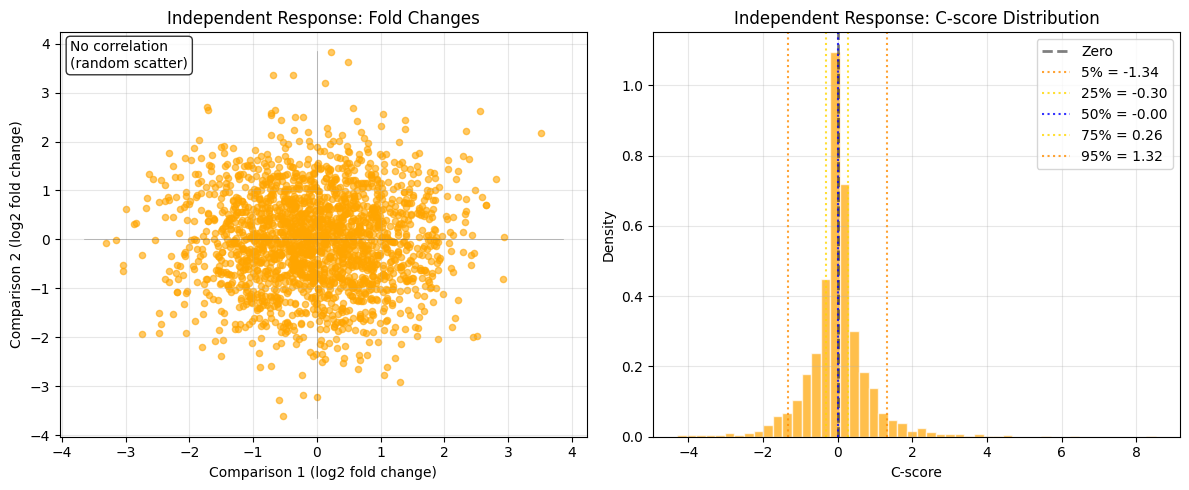

In [8]:
# Visualize the independent response scenario
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot of fold changes
ax1.scatter(comp1_indep[:, 0], comp2_indep[:, 0], alpha=0.6, s=20, color='orange')
ax1.set_xlabel('Comparison 1 (log2 fold change)')
ax1.set_ylabel('Comparison 2 (log2 fold change)')
ax1.set_title('Independent Response: Fold Changes')
ax1.grid(True, alpha=0.3)

# Add reference lines
lims = ax1.get_xlim()
ax1.plot(lims, [0, 0], 'k-', alpha=0.3, linewidth=0.5)  # Horizontal line
ax1.plot([0, 0], lims, 'k-', alpha=0.3, linewidth=0.5)  # Vertical line
ax1.text(0.02, 0.98, 'No correlation\n(random scatter)', transform=ax1.transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Histogram of C-scores with quantile markers
ax2.hist(scores_independent, bins=50, alpha=0.7, color='orange', edgecolor='white', density=True)
ax2.axvline(0, color='black', linestyle='--', alpha=0.5, linewidth=2, label='Zero')

# Add quantile lines
quantiles_to_show = [0.05, 0.25, 0.5, 0.75, 0.95]
colors = ['darkorange', 'gold', 'blue', 'gold', 'darkorange']
for q, color in zip(quantiles_to_show, colors):
    value = np.quantile(scores_independent, q)
    ax2.axvline(value, color=color, linestyle=':', alpha=0.8, 
                label=f'{q*100:.0f}% = {value:.2f}')

ax2.set_xlabel('C-score')
ax2.set_ylabel('Density')
ax2.set_title('Independent Response: C-score Distribution')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()


## Scenario 2: Common Responses

Now let's examine genes that respond similarly in both comparisons:

In [9]:
# Generate common response data
comp1_common, comp2_common = generate_gene_data(n_genes=2000, scenario="common", seed=42)

# Compute C-scores
scores_common = compute_score(comp1_common, comp2_common)

# Display statistics
print(f"C-score Statistics:")
print(f"Mean: {np.mean(scores_common):.3f}")
print(f"Std:  {np.std(scores_common):.3f}")
print(f"Range: [{np.min(scores_common):.3f}, {np.max(scores_common):.3f}]")

positive_pct = np.mean(scores_common > 0) * 100
negative_pct = np.mean(scores_common < 0) * 100
zero_pct = np.mean(scores_common == 0) * 100

print(f"\nScore Distribution:")
print(f"Positive (common): {positive_pct:.1f}%")
print(f"Negative (divergent): {negative_pct:.1f}%")
print(f"Zero: {zero_pct:.1f}%")

# Print quantiles
quantiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
print(f"\nQuantiles:")
for q in quantiles:
    value = np.quantile(scores_common, q)
    print(f"  {q*100:4.0f}%: {value:7.3f}")


📊 Common scenario: Genes respond similarly in both comparisons
   Generated 2,000 genes (20% significant)
C-score Statistics:
Mean: 0.768
Std:  1.409
Range: [-0.425, 14.915]

Score Distribution:
Positive (common): 89.5%
Negative (divergent): 10.5%
Zero: 0.0%

Quantiles:
     1%:  -0.140
     5%:  -0.027
    25%:   0.053
    50%:   0.252
    75%:   0.855
    95%:   3.284
    99%:   6.854


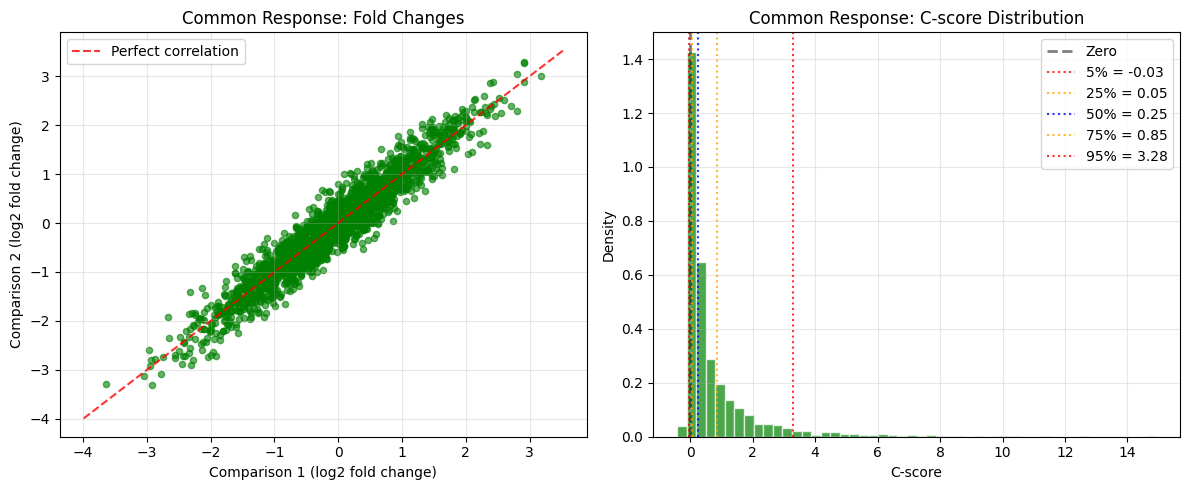

In [10]:
# Visualize the common response scenario
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot of fold changes
ax1.scatter(comp1_common[:, 0], comp2_common[:, 0], alpha=0.6, s=20, color='green')
ax1.set_xlabel('Comparison 1 (log2 fold change)')
ax1.set_ylabel('Comparison 2 (log2 fold change)')
ax1.set_title('Common Response: Fold Changes')
ax1.grid(True, alpha=0.3)

# Add diagonal line (perfect correlation)
lims = ax1.get_xlim()
ax1.plot(lims, lims, 'r--', alpha=0.8, label='Perfect correlation')
ax1.legend()

# Histogram of C-scores with quantile markers
ax2.hist(scores_common, bins=50, alpha=0.7, color='green', edgecolor='white', density=True)
ax2.axvline(0, color='black', linestyle='--', alpha=0.5, linewidth=2, label='Zero')

# Add quantile lines
quantiles_to_show = [0.05, 0.25, 0.5, 0.75, 0.95]
colors = ['red', 'orange', 'blue', 'orange', 'red']
for q, color in zip(quantiles_to_show, colors):
    value = np.quantile(scores_common, q)
    ax2.axvline(value, color=color, linestyle=':', alpha=0.8, 
                label=f'{q*100:.0f}% = {value:.2f}')

ax2.set_xlabel('C-score')
ax2.set_ylabel('Density')
ax2.set_title('Common Response: C-score Distribution')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()


## Scenario 3: Divergent Responses

Finally, let's examine genes that respond oppositely in the two comparisons:


In [11]:
# Generate divergent response data
comp1_div, comp2_div = generate_gene_data(n_genes=2000, scenario="divergent", seed=123)

# Compute C-scores
scores_divergent = compute_score(comp1_div, comp2_div)

# Display statistics
print(f"C-score Statistics:")
print(f"Mean: {np.mean(scores_divergent):.3f}")
print(f"Std:  {np.std(scores_divergent):.3f}")
print(f"Range: [{np.min(scores_divergent):.3f}, {np.max(scores_divergent):.3f}]")

positive_pct = np.mean(scores_divergent > 0) * 100
negative_pct = np.mean(scores_divergent < 0) * 100
zero_pct = np.mean(scores_divergent == 0) * 100

print(f"\nScore Distribution:")
print(f"Positive (common): {positive_pct:.1f}%")
print(f"Negative (divergent): {negative_pct:.1f}%")
print(f"Zero: {zero_pct:.1f}%")

# Print quantiles
quantiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
print(f"\nQuantiles:")
for q in quantiles:
    value = np.quantile(scores_divergent, q)
    print(f"  {q*100:4.0f}%: {value:7.3f}")


📊 Divergent scenario: Genes respond oppositely in the two comparisons
   Generated 2,000 genes (20% significant)
C-score Statistics:
Mean: -0.713
Std:  1.092
Range: [-8.748, 0.343]

Score Distribution:
Positive (common): 8.9%
Negative (divergent): 91.1%
Zero: 0.0%

Quantiles:
     1%:  -5.301
     5%:  -2.952
    25%:  -0.868
    50%:  -0.289
    75%:  -0.069
    95%:   0.016
    99%:   0.083


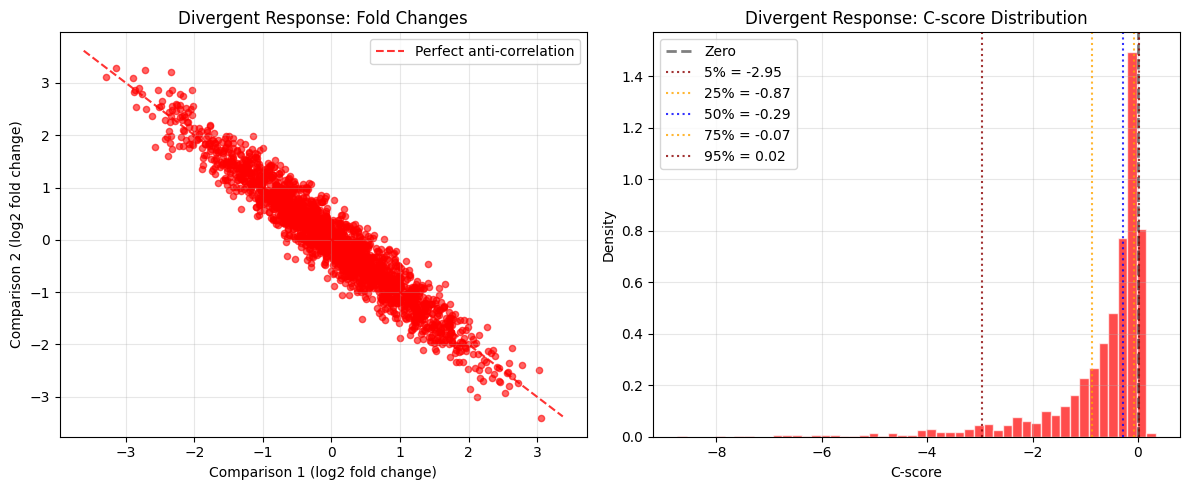

In [13]:
# Visualize the divergent response scenario
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot of fold changes
ax1.scatter(comp1_div[:, 0], comp2_div[:, 0], alpha=0.6, s=20, color='red')
ax1.set_xlabel('Comparison 1 (log2 fold change)')
ax1.set_ylabel('Comparison 2 (log2 fold change)')
ax1.set_title('Divergent Response: Fold Changes')
ax1.grid(True, alpha=0.3)

# Add anti-diagonal line (perfect anti-correlation)
lims = ax1.get_xlim()
ax1.plot(lims, [-lims[0], -lims[1]], 'r--', alpha=0.8, label='Perfect anti-correlation')
ax1.legend()

# Histogram of C-scores with quantile markers
ax2.hist(scores_divergent, bins=50, alpha=0.7, color='red', edgecolor='white', density=True)
ax2.axvline(0, color='black', linestyle='--', alpha=0.5, linewidth=2, label='Zero')

# Add quantile lines
quantiles_to_show = [0.05, 0.25, 0.5, 0.75, 0.95]
colors = ['darkred', 'orange', 'blue', 'orange', 'darkred']
for q, color in zip(quantiles_to_show, colors):
    value = np.quantile(scores_divergent, q)
    ax2.axvline(value, color=color, linestyle=':', alpha=0.8, 
                label=f'{q*100:.0f}% = {value:.2f}')

ax2.set_xlabel('C-score')
ax2.set_ylabel('Density')
ax2.set_title('Divergent Response: C-score Distribution')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()


## Scenario Comparison

Let's compare all three scenarios side by side:


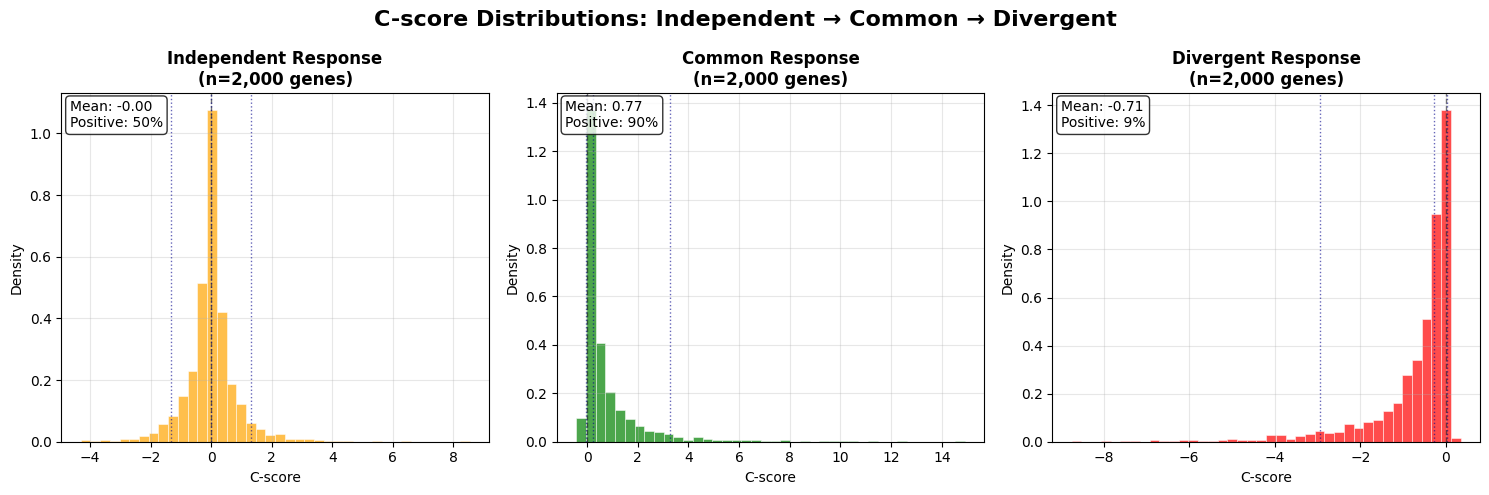

In [14]:
# Create comprehensive comparison
scenarios = {
    'Independent': scores_independent,
    'Common': scores_common,
    'Divergent': scores_divergent
}

colors = ['orange', 'green', 'red']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (name, scores) in enumerate(scenarios.items()):
    ax = axes[i]
    
    # Create histogram
    ax.hist(scores, bins=40, alpha=0.7, color=colors[i], edgecolor='white', linewidth=0.5, density=True)
    
    # Add vertical line at zero
    ax.axvline(0, color='black', linestyle='--', alpha=0.5, linewidth=1)
    
    # Add quantile lines
    quantiles_to_show = [0.05, 0.5, 0.95]
    for q in quantiles_to_show:
        value = np.quantile(scores, q)
        ax.axvline(value, color='darkblue', linestyle=':', alpha=0.6, linewidth=1)
    
    # Formatting
    ax.set_title(f'{name} Response\n(n={len(scores):,} genes)', fontweight='bold')
    ax.set_xlabel('C-score')
    ax.set_ylabel('Density')
    ax.grid(True, alpha=0.3)
    
    # Add statistics text box
    mean_score = np.mean(scores)
    pos_pct = np.mean(scores > 0) * 100
    
    stats_text = f'Mean: {mean_score:.2f}\nPositive: {pos_pct:.0f}%'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
            verticalalignment='top', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('C-score Distributions: Independent → Common → Divergent', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [15]:
# Create detailed summary statistics table
summary_data = []

for name, scores in scenarios.items():
    # Calculate quantiles
    q01, q05, q25, q50, q75, q95, q99 = np.quantile(scores, [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
    
    summary_data.append({
        'Scenario': name,
        'Mean': f"{np.mean(scores):.3f}",
        'Std': f"{np.std(scores):.3f}",
        'Min': f"{np.min(scores):.3f}",
        'Max': f"{np.max(scores):.3f}",
        '1%': f"{q01:.3f}",
        '5%': f"{q05:.3f}",
        '25%': f"{q25:.3f}",
        'Median': f"{q50:.3f}",
        '75%': f"{q75:.3f}",
        '95%': f"{q95:.3f}",
        '99%': f"{q99:.3f}",
        'Positive %': f"{np.mean(scores > 0) * 100:.1f}%",
        'Negative %': f"{np.mean(scores < 0) * 100:.1f}%"
    })

summary_df = pd.DataFrame(summary_data)

print("Comprehensive C-score Summary Statistics")
print("=" * 100)
print(summary_df.to_string(index=False))

print("\nKey Insights:")
print("• Independent scenario: Near-zero mean, symmetric distribution around zero (baseline)")
print("• Common scenario: Strongly positive mean, 89%+ positive scores")
print("• Divergent scenario: Strongly negative mean, 89%+ negative scores") 
print("• Range of C-scores: Typically between -3 to +3 for these simulations")


Comprehensive C-score Summary Statistics
   Scenario   Mean   Std    Min    Max     1%     5%    25% Median    75%   95%   99% Positive % Negative %
Independent -0.003 0.882 -4.307  8.530 -2.506 -1.339 -0.301 -0.003  0.264 1.323 2.856      49.6%      50.4%
     Common  0.768 1.409 -0.425 14.915 -0.140 -0.027  0.053  0.252  0.855 3.284 6.854      89.5%      10.5%
  Divergent -0.713 1.092 -8.748  0.343 -5.301 -2.952 -0.868 -0.289 -0.069 0.016 0.083       8.9%      91.1%

Key Insights:
• Independent scenario: Near-zero mean, symmetric distribution around zero (baseline)
• Common scenario: Strongly positive mean, 89%+ positive scores
• Divergent scenario: Strongly negative mean, 89%+ negative scores
• Range of C-scores: Typically between -3 to +3 for these simulations
